In [77]:
import numpy as np
import torch
from lib.models import iVAE
from lib.iFlow import iFlow
from lib.metrics import mean_corr_coef as mcc
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


In [99]:
def correlation_coefficients(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.

    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
                The options are 'pearson' and 'spearman'
                'pearson':
                    use Pearson's correlation coefficient
                'spearman':
                    use Spearman's nonparametric rank correlation coefficient
    :return: float
    """
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    elif method == 'spearman':
        cc = spearmanr(x, y)[0][:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
    cc_matrix = np.abs(cc)

    corr_coefs = cc_matrix[linear_sum_assignment(-1 * cc_matrix)] #.mean()
    return corr_coefs, cc_matrix

### Load model checkpoint

In [100]:
# Similar to running the command:
# python main.py --data-args=100_5_2_2_3_1_gauss_xtanh_u_f --epochs=20 --batch-size=4 --i-what=iFlow --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu
# and using default values for other arguments.
metadata = {'file': 'data/1/tcl_100_5_2_2_3_1_gauss_xtanh_u.npz',
            'latent_dim': 2, 'batch_size': 4, 'epochs': 1, 
            'max_iter': None, 'hidden_dim': 50, 'depth': 3, 
            'lr': 0.001, 'seed': 1, 'cuda': True, 'preload': True, 
            'anneal': False, 'log_freq': 25, 'i_what': 'iFlow', 
            'flow_type': 'RQNSF_AG', 'num_bins': 8, 
            'nat_param_act': 'Softplus', 'gpu_id': '0', 
            'flow_length': 10, 'lr_drop_factor': 0.5, 
            'lr_patience': 10, 
            'path': 'data/1/tcl_100_5_2_2_3_1_gauss_xtanh_u.npz', 
            'nps': 100, 'ns': 5, 'n': 500, 'data_dim': 2, 
            'aux_dim': 5, 'device': torch.device(type='cuda')}




model = iFlow(args=metadata).to(device)

CKPT_PATH = "experiments/2021-01-14_181214/ckpt/1/1_ckpt_100.pth"
model.load_state_dict(torch.load(CKPT_PATH), strict=False)
model.eval()


iFlow(
  (nf): SplineFlow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): CompositeTransform(
          (_transforms): ModuleList(
            (0): CompositeTransform(
              (_transforms): ModuleList(
                (0): RandomPermutation()
                (1): LULinear()
              )
            )
            (1): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
              (autoregressive_net): MADE(
                (initial_layer): MaskedLinear(in_features=2, out_features=256, bias=True)
                (blocks): ModuleList(
                  (0): MaskedResidualBlock(
                    (linear_layers): ModuleList(
                      (0): MaskedLinear(in_features=256, out_features=256, bias=True)
                      (1): MaskedLinear(in_features=256, out_features=256, bias=True)
                    )
                    (dropout): Dropout(p=0.25, inplace=False)
                  )
                  (1): MaskedResidualB

In [59]:
# specify dataset location
DATA_PATH = "data/1/tcl_100_5_2_2_3_1_gauss_xtanh_u.npz"
data_args = "100_5_2_2_3_1_gauss_xtanh_u_f"

if model.__class__.__name__ == 'iFlow':
    import operator
    from functools import reduce
    total_num_examples = reduce(operator.mul, map(int, data_args.split('_')[:2]))
    model.set_mask(total_num_examples)

A = np.load(DATA_PATH)
x = A['x']
x = torch.from_numpy(x).to(device)
print("x.shape ==", x.shape)

s = A['s']
print("s.shape ==", s.shape)

u = A['u'] 
u = torch.from_numpy(u).to(device)
print("u.shape ==", u.shape)

if model.__class__.__name__ == 'iVAE':
    _, z_est = model.elbo(x, u)
elif model.__class__.__name__ == 'iFlow':
    z_est, nat_params = model.inference(x, u)

z_est = z_est.cpu().detach().numpy()
# os.makedirs(Z_EST_FOLDER)
# np.save("{}/z_est.npy".format(Z_EST_FOLDER), z_est)
# if args.i_what == 'iFlow':
#     nat_params = nat_params.cpu().detach().numpy()
#     np.save("{}/nat_params.npy".format(Z_EST_FOLDER), nat_params)
print("z_est.shape ==", z_est.shape)

perf = mcc(s, z_est)
print("EVAL PERFORMANCE: {}".format(perf))

corr_coefs, cc_matrix = correlation_coefficients(s, z_est)
print("CORRELATION MATRIX: \n{}".format(cc_matrix))
print("CORRELATION COEFFICIENTS: {}".format(corr_coefs))
print("DONE.")



x.shape == torch.Size([500, 2])
s.shape == (500, 2)
u.shape == torch.Size([500, 5])
z_est.shape == (500, 2)
EVAL PERFORMANCE: 0.6564191468405156
CORRELATION MATRIX: 
[[0.06828436 0.43677264]
 [0.87606565 0.61908498]]
CORRELATION COEFFICIENTS: [0.43677264 0.87606565]
DONE.


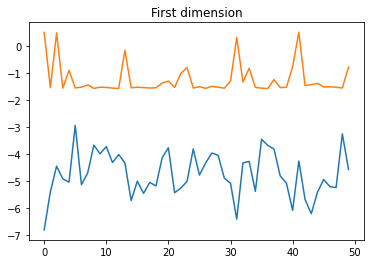

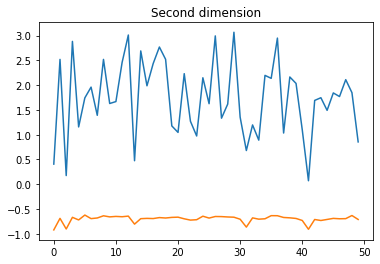

In [98]:
true_y_dim1 = s[:,[0]]
true_y_dim2 = s[:,[1]]
y_dim1 = z_est[:, [0]]
y_dim2 = z_est[:, [1]]


# plt.plot(true_y_dim1)
# plt.plot(y_dim1)
# plt.show()

# plt.plot(true_y_dim2)
# plt.plot(y_dim2)
# plt.show()

plt.plot(true_y_dim1[200:250])
plt.plot(y_dim1[200:250])
plt.title('First dimension')
plt.show()

plt.plot(true_y_dim2[200:250])
plt.plot(y_dim2[200:250])
plt.title('Second dimension')
plt.show()

In [4]:
# Initialize model with correct arguments
# latent_dim = 2
# data_dim = 2
# aux_dim = 5
# n_layers = 3
# activation = 'lrelu'
# device = torch.device('cuda')
# hidden_dim = 50
# anneal = False


# model = iVAE(latent_dim, \
#                  data_dim, \
#                  aux_dim, \
#                  n_layers, \
#                  activation, \
#                  device, \
#                  hidden_dim, \
#                  anneal) # False


# model.load_state_dict(torch.load(PATH))
# model.eval()


NameError: name 'iVAE' is not defined